# Setup

In [91]:
import numpy as np
import matplotlib.pyplot as plt

Define simulation parameters

In [92]:
grid_pts = 7  # number of grid spacings in x and y dirs
hist_locs = [[4,1], [3,3], [1,4]] # locations of points to store, in matrix indices


## `residuals()`
Before we define the `solve_laplace` function, we must first define the residuals function.

We are given $R_{i,j} = \psi_{i,j+1}+\psi_{i,j-1}+\psi_{i-1,j}+\psi_{i+1,j}-4\psi_{i,j}$. This expression is modified slightly as detailed in the code to account for edges of the grid

In [93]:
def residuals(psi_grid: np.ndarray, row: int, col: int) -> float:
    """
    Author: Jack Barker, Date: 12/12/2022
    Calculates the residual of a given position and grid state, as defined in
    equation 6 of the lab script. If we are on the edge of the grid, we only add
    the terms that are defined, and do not subtract an extra psi_{i,j}. We also perform
    the division here, so we can account for the fact we might be on an edge.

    Parameters:
    :param psi_grid: Current state of the simulation.
    :row: row number, corrected for difference between matrix indices and grid position
    :col: col number, corrected for difference between matrix indices and grid position

    Returns:
    :residual: The residual of the given position in the given grid state.

    Constraints:
    :psi_grid: Must be a square matrix
    :row: Must be an integer between 0 and grid_pts-1
    :col: Must be an integer between 0 and grid_pts-1
    """

    # check constraints
    assert psi_grid.shape[0] == psi_grid.shape[1], "psi_grid must be a square matrix"

    grid_pts = psi_grid.shape[0]
    assert 0 <= row < grid_pts, "row must be an integer between 0 and grid_pts-1"
    assert 0 <= col < grid_pts, "col must be an integer between 0 and grid_pts-1"
    
    # we now check if we are on any edges. If we are not on a given edge, we add the
    # corresponding term from the definition of a residual.
    # Note that if we are not on an edge, this process reproduces the normal expression.
    # we also keep track of the number of terms we add, so we can add the corresponding
    # number of psi_{i,j}s and divide by this later.

    residual = 0
    current = psi_grid[row][col]

    count = 0
    if row != 0:
        # not on "top" edge of matrix
        residual += psi_grid[row - 1][col]
        count += 1
    if row != grid_pts - 1:
        # not on "bottom" edge of matrix
        residual += psi_grid[row + 1][col]
        count += 1
    if col != 0:
        # not on "left" edge of matrix
        residual += psi_grid[row][col - 1]
        count += 1
    if col != grid_pts - 1:
        # not on "right" edge of matrix
        residual += psi_grid[row][col + 1]
        count += 1

    return (residual-current*count)/count


## `solve_laplace()`

Having defined `residuals`, I can now write the actual Laplace solver.

In [94]:
def solve_laplace(init_psi: np.ndarray, alpha: float, N_iter: int) -> list[np.ndarray]:
    """
    Author: Jack Barker, Date: 12/12/2022
    Solves Laplace's equation using over-relaxation method.

    Parameters:
    :param init_psi: 2D matrix contianing initial values for psi over the grid
    :param alpha: Coefficient of over-relaxation
    :param N_iter: Maximum number of allowed iterations

    Returns:
    :new_psi: 2D matrix containing final values for psi over the grid
    :hist_values: 2D matrix containing values of three points for each iteration

    Constraints:
    :init_psi: Must be a square matrix


    """
    # check constraints
    assert init_psi.shape[0] == init_psi.shape[1], "init_psi must be a square matrix"

    grid_pts = init_psi.shape[0]  # number of grid spacings in x and y dirs

    # initialise new_psi array with same shape as init_psi. We use .copy() to ensure
    # that we are not just copying the reference to the array, but the actual array
    new_psi = init_psi.copy()

    # create an array to store historical values of three points
    hist_values = np.zeros((3, N_iter))

    converged = False # flag to indicate if the simulation has converged


    # implement equation 5 from lab script, with slight adjustment to account for
    # the fact some terms are not defined on the edges of the grid
    # (see residuals() for more details)

    for i in range(N_iter):
        # iterate over all x and y positions in the grid. We want to iterate from the
        # boundaries where psi is non-zero

        # store values of three points
        for j,loc in enumerate(hist_locs):
            hist_values[j,i] = new_psi[loc[0],loc[1]]

        prev = new_psi.copy() # store previous iteration to check convergence

        for row in range(grid_pts):
            # y=1 boundary is the top of the matrix, so we iterate from row 0
            for col in range(grid_pts - 1, -1, -1):
                # x=1 boundary is the right, so we iterate from the final col

                # re-impose boundary conditions
                new_psi[:, 0] = 0  # x=0
                new_psi[-1, :] = 0  # y=0
                new_psi[:, -1] = np.flip(
                    np.sin(1) * np.sinh(np.linspace(0, 1, grid_pts))
                )  # x=1
                new_psi[0, :] = np.sin(np.linspace(0, 1, grid_pts)) * np.sinh(1)  # y=1

                # apply equation 5 (note that the division of the residual is done
                # inside the residuals() function)
                new_psi[row][col] = new_psi[row][col] + alpha * residuals(
                    new_psi, row, col
                )
        
        # test for convergence
        if np.allclose(prev, new_psi, rtol=1e-5, atol=1e-8):
            converged = True
            print(f"Converged after {i} iterations")
            # if we terminate early, we have to remove the extra values from hist_values
            hist_values = hist_values[:,:i]
            break

    if not converged:
        print(f"Failed to converge after {N_iter} iterations")
    return [new_psi, hist_values]


# Laplace Computation

## Analytic Solution
First part: Check numerical solution against a known analytic solution. For the problem posed in the lab script, the solution is $\psi(x,y) = \sin{x}\sinh{y}$. Plotting this:

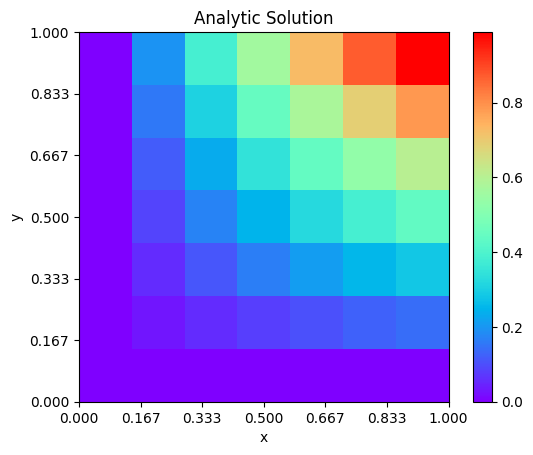

In [95]:
def analytic_solution(x, y):
    """
    Retuns the analytic solution to Laplace's equation with boundary conditions as
    defined in lab script.
    """
    return np.sin(x)*np.sinh(y)

# create a grid of x and y values for calculating the analytic solution
x = np.linspace(0, 1, grid_pts)
y = np.linspace(0, 1, grid_pts)
X, Y = np.meshgrid(x, y)
Y = np.flip(Y)

# define bounds for heatmap ticks
extent = [0, 1, 0, 1]

plt.imshow(analytic_solution(X, Y), cmap="rainbow", interpolation="nearest",extent=extent)

# fix the ticks on the heatmap
plt.yticks(y)
plt.xticks(x)

# style the heatmap
plt.title("Analytic Solution")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.show()

Numeric solution:

Converged after 12 iterations


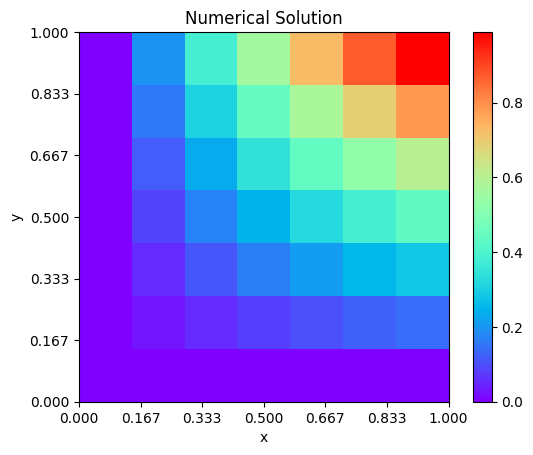

In [96]:
# initialise the grid with the boundary conditions
x = np.linspace(0, 1, grid_pts)
y = np.linspace(0, 1, grid_pts)

psi_grid = np.zeros((grid_pts, grid_pts))
# we already have psi(x,0) = psi(0,y) = 0, so we only need to set the top and right
# edges of the grid

# BC on x=1. x=1 corresponds to the last column of the matrix
# we need to flip the y values, as the y axis is flipped in the matrix
psi_grid[:,-1] = np.flip(np.sin(1)*np.sinh(x))

# BC on y=1. y=1 corresponds to the first row of the matrix
psi_grid[0,:] = np.sin(x)*np.sinh(1)

psi_grid = solve_laplace(psi_grid, 1.35, 30)[0]

plt.imshow(psi_grid, cmap="rainbow", interpolation="nearest",extent=extent)
plt.yticks(y)
plt.xticks(x)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Numerical Solution")
plt.colorbar()
plt.show()

## Convergence

Now that we have established the code works, we consider some points and compare the rate of convergence for some different $\alpha$ values

Converged after 29 iterations
Converged after 19 iterations
Converged after 12 iterations
Converged after 15 iterations
Failed to converge after 30 iterations


C:\Users\jwbar\AppData\Local\Temp\ipykernel_15308\1589966770.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


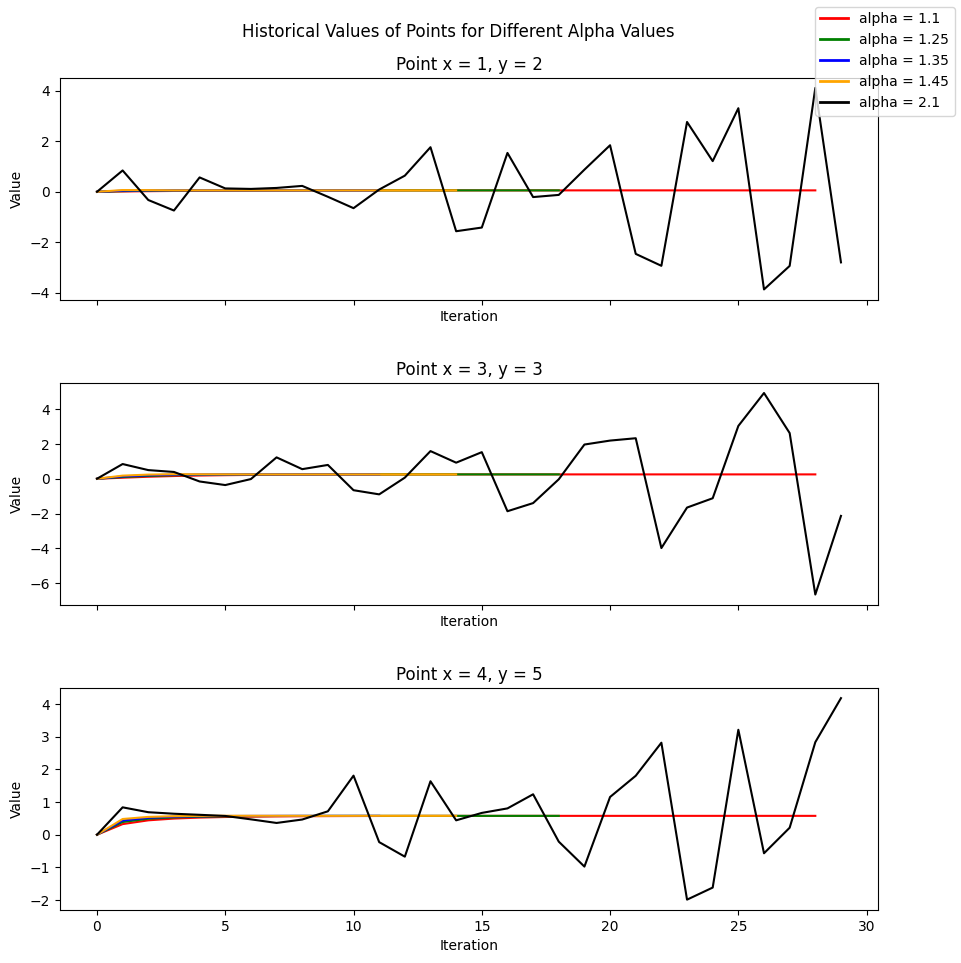

In [97]:
from matplotlib.lines import Line2D
alpha_vals = [1.1, 1.25, 1.35, 1.45, 2.1]

# set up the inital psi grid, as before
init_psi = np.zeros((grid_pts, grid_pts))
init_psi[:,-1] = np.flip(np.sin(1)*np.sinh(x))
init_psi[0,:] = np.sin(x)*np.sinh(1)

# for each point that historical values are recorded at, create a subpolot
fig, axs = plt.subplots(len(hist_locs), sharex=True, figsize = (10,10))
fig.tight_layout(pad=5.0) # makes sure the subplots don't overlap

colours = ["red", "green", "blue", "orange", "black"] # colour for each alpha value
for i, alpha in enumerate(alpha_vals):
    # solve the laplace equation for each alpha value and record the historical values
    hist_values = solve_laplace(init_psi, alpha, 30)[1]

    for j, values in enumerate(hist_values):
        # plot the historical values for each point
        axs[j].plot(values, color=colours[i])

# create a custom legend for the subplots
lines = [Line2D([0], [0], color=c, linewidth=2, linestyle="-") for c in colours]
fig.legend(lines, [f"alpha = {a}" for a in alpha_vals], loc="upper right")

# style the figure
fig.suptitle("Historical Values of Points for Different Alpha Values")
for i, loc in enumerate(hist_locs):
    axs[i].set_title(f"Point x = {loc[1]}, y = {grid_pts-1-loc[0]}")
    axs[i].set_xlabel("Iteration")
    axs[i].set_ylabel("Value")
fig.show()

    

## Contour plotting

I now finally produce the required contour plots

Converged after 12 iterations


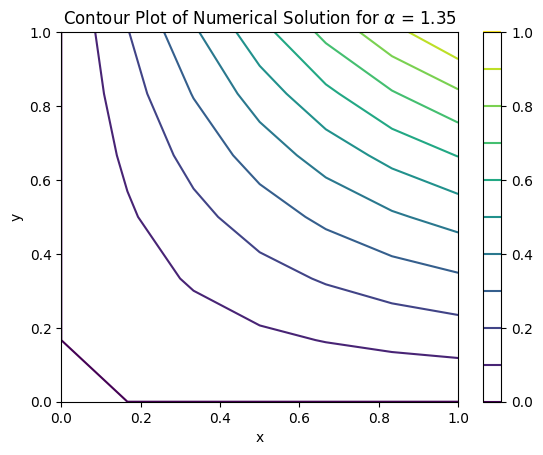

In [98]:
# The plt.contour() function requires x, y and z values. The x and y values are
# just the locations on the grid, and the z values are the values of psi

x = np.linspace(0, 1, grid_pts)
y = np.linspace(0, 1, grid_pts)
X, Y = np.meshgrid(x, y)
Y = np.flip(Y)

# set up the inital psi grid, as before
init_psi = np.zeros((grid_pts, grid_pts))
init_psi[:,-1] = np.flip(np.sin(1)*np.sinh(x))
init_psi[0,:] = np.sin(x)*np.sinh(1)

# this time we are not interested in the historical values
alpha = 1.35
z = solve_laplace(init_psi, alpha, 30)[0]
plt.contour(X, Y, z, 10)
plt.colorbar()
plt.ylabel("y")
plt.xlabel("x")
plt.title(f"Contour Plot of Numerical Solution for $\\alpha$ = {alpha}")
plt.show()


# Poission

We start by modifing `laplace_solver` to solve Poisson's equation

In [99]:
def solve_poisson(
    init_psi: np.ndarray, fixed_psi: np.ndarray, source: np.ndarray, N_iter: int = 60
):
    """
    Author: Jack Barker, Date: 13/12/2022
    Solves Poisson's equation using over-relaxation method.

    Parameters:
    :param init_psi: 2D matrix contianing initial values for psi over the grid.
    :param fixed psi: 2D matrix of bools that flags which points in the grid are fixed.
    :param source: 2D matrix containing values for the source term over the grid.

    Returns:
    :new_psi: 2D matrix containing final values for psi over the grid.

    Constraints:
    :init_psi, :fixed_psi, :source: Must be square, with the same size.
    """

    # check that the input matrices are square and the same size
    assert init_psi.shape == fixed_psi.shape
    assert init_psi.shape == source.shape
    assert init_psi.shape[0] == init_psi.shape[1]

    grid_pts = init_psi.shape[0]  # number of grid spacings in x and y dirs

    # initialise new_psi array with same shape as init_psi. We use .copy() to ensure
    # that we are not just copying the reference to the array, but the actual array
    new_psi = init_psi.copy()

    converged = False  # flag to indicate if the simulation has converged

    delta = 1 / (grid_pts - 1)  # grid spacing

    for i in range(N_iter):
        prev = new_psi.copy()  # store previous iteration

        for row in range(grid_pts):
            for col in range(grid_pts):
                if not fixed_psi[row][col]:
                    # apply successive over-relaxation method
                    new_psi[row][col] = (
                        new_psi[row][col]
                        + alpha * residuals(new_psi, row, col)
                        - alpha * delta**2 * source[row][col] / 4
                    )

        # test for convergence
        if np.allclose(prev, new_psi, rtol=1e-5, atol=1e-8):
            converged = True
            print(f"Converged after {i} iterations")
            break

    if not converged:
        print(f"Failed to converge after {N_iter} iterations")
    return new_psi


We now consider a variety of different source conditions

## Line charges in earthed container

To speed up this process, I have written a function line_charges to produce various configurations quickly

In [100]:
def line_charges(
    q: list[float],
    loc: list[list[int]],
    fixed_psi: np.ndarray,
    contours: int,
    alpha: float = 1.35,
) -> plt:
    """
    Author: Jack Barker, Date: 13/12/2022
    Produces a plot of the potential due to line charges.

    Parameters:
    :param q: List containing Charge in Coulombs for each line charge.
    :param loc: List of grid locations to put the line charge (in grid coordinates).
    :param fixed_psi: 2D matrix of bools that flags which points in the grid are fixed.
                      Used to set other points to zero (eg. edges).
    :param contours: Number of contours to plot.
    :param alpha: Over-relaxation parameter.
    
    Returns:
    :new_psi: 2D matrix containing final values for psi over the grid.

    Constraints:
    :q, :loc: Must be the same length.
    :fixed_psi: Must be square.
    """

    assert len(q) == len(loc)  # check that there is a charge for each location
    assert fixed_psi.shape[0] == fixed_psi.shape[1]  # check that fixed_psi is square

    grid_pts = fixed_psi.shape[0]  # number of grid spacings in x and y dirs

    source = np.zeros((grid_pts, grid_pts))  # initialise source array

    # populate the source array with the line charges and set these as fixed points
    for i, charge in enumerate(q):
        source[*loc[i]] = charge
        fixed_psi[*loc[i]] = True

    # solve Poisson's equation
    init_psi = source
    psi = solve_poisson(init_psi, fixed_psi, source)

    # set up the x and y values for the contour plot
    x = np.linspace(0, 1, grid_pts)
    y = np.linspace(0, 1, grid_pts)
    X, Y = np.meshgrid(x, y)
    Y = np.flip(Y)

    # plot the contour plot
    fig = plt.figure()
    plt.contour(X, Y, psi, contours-1)
    plt.ylabel("y")
    plt.xlabel("x")
    plt.colorbar()

    return fig

Line charge at centre of insulated box (5x5 grid)

Converged after 12 iterations


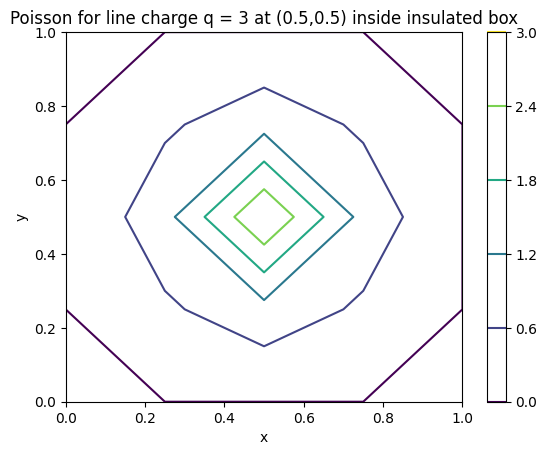

In [101]:

fixed_psi = np.zeros((5,5), dtype=bool)
fixed_psi[0,:] = True
fixed_psi[-1,:] = True
fixed_psi[:,0] = True
fixed_psi[:,-1] = True
f=line_charges([3], [[2,2]], fixed_psi, 5)
plt.title(f"Poisson for line charge q = 3 at (0.5,0.5) inside insulated box")
plt.show()

Line charges at other places

Converged after 15 iterations


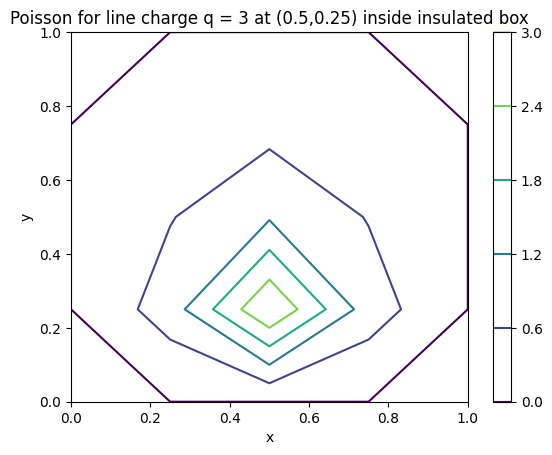

In [102]:
fixed_psi = np.zeros((5,5), dtype=bool)
fixed_psi[0,:] = True
fixed_psi[-1,:] = True
fixed_psi[:,0] = True
fixed_psi[:,-1] = True
f=line_charges([3], [[3,2]], fixed_psi, 5)
plt.title(f"Poisson for line charge q = 3 at (0.5,0.25) inside insulated box")
plt.show()

Converged after 12 iterations


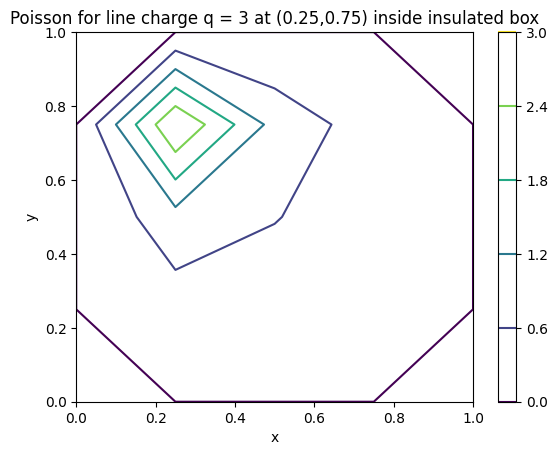

In [103]:
fixed_psi = np.zeros((5,5), dtype=bool)
fixed_psi[0,:] = True
fixed_psi[-1,:] = True
fixed_psi[:,0] = True
fixed_psi[:,-1] = True
f=line_charges([3], [[1,1]], fixed_psi, 5)
plt.title(f"Poisson for line charge q = 3 at (0.25,0.75) inside insulated box")
plt.show()

## Dipoles

We now consider some dipole configurations, and move to a 7x7 grid for greater resolution

First, dipole at centre of unearthed box

Failed to converge after 60 iterations


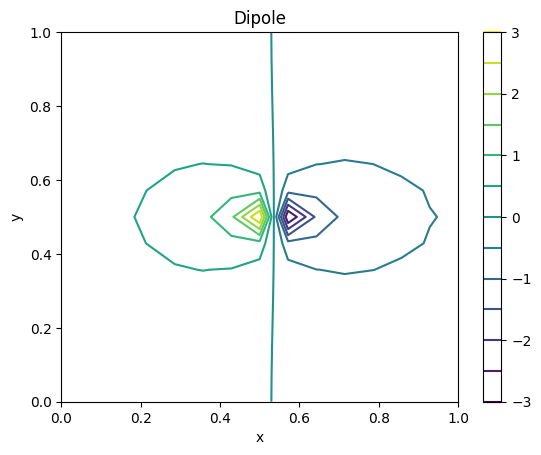

In [109]:
fixed_psi = np.zeros((15,15), dtype=bool)
f=line_charges([3,-3], [[7,7], [7,8]], fixed_psi, 12)
plt.title(f"Dipole")
plt.show()

Failed to converge after 60 iterations


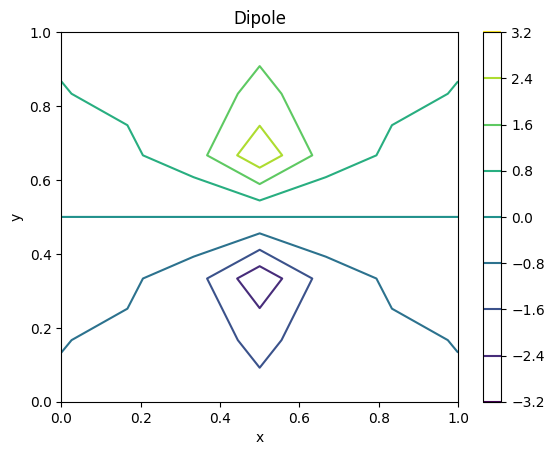

In [110]:
fixed_psi = np.zeros((7,7), dtype=bool)
f=line_charges([3,-3], [[2,3], [4,3]], fixed_psi, 8)
plt.title(f"Dipole")
plt.show()

# Fluid Motion

In [112]:
def solve_fluid(
    init_psi: np.ndarray,
    fixed_psi: np.ndarray,
    boundaries: np.ndarray,
    N_iter: int = 60,
    alpha: float = 1.35,
) -> np.ndarray:
    """
    Author: Jack Barker, Date: 12/12/2022
    Solves Laplace's equation with more complex boundary conditions.
    Boundary conditions are imposed where fixed_psi is True.

    Parameters:
    :param init_psi: 2D matrix contianing initial values for psi over the grid
    :param fixed psi: 2D matrix of bools that flags which points in the grid
                      are fixed to boundary conditions.
    :param boundaries: 2D matrix containing boundary conditions.
    :param N_iter: Number of iterations to perform.
    :param alpha: Over-relaxation parameter.

    Returns:
    :new_psi: 2D matrix containing final values for psi over the grid

    Constraints:
    :init_psi, :fixed_psi, :boundaries: Must be square, with the same size.
    """

    # check that the input matrices are square and the same size
    assert init_psi.shape == fixed_psi.shape
    assert init_psi.shape == boundaries.shape
    assert init_psi.shape[0] == init_psi.shape[1]

    grid_pts = init_psi.shape[0]  # number of grid spacings in x and y dirs

    # initialise new_psi array with same shape as init_psi. We use .copy() to ensure
    # that we are not just copying the reference to the array, but the actual array
    new_psi = init_psi.copy()

    converged = False  # flag to indicate if the simulation has converged

    # impose boundary conditions
    for row in range(grid_pts):
        for col in range(grid_pts):
            if fixed_psi[row][col]:
                new_psi[row][col] = boundaries[row][col]

    for i in range(N_iter):
        prev = new_psi.copy()  # store previous iteration to check convergence

        for row in range(grid_pts):
            for col in range(grid_pts):
                # skip points that are fixed to boundary conditions
                if not fixed_psi[row][col]:
                    # apply equation 5
                    new_psi[row][col] = new_psi[row][col] + alpha * residuals(
                        new_psi, row, col
                    )

        # test for convergence
        if np.allclose(prev, new_psi, rtol=1e-5, atol=1e-8):
            converged = True
            print(f"Converged after {i} iterations")
            break

    if not converged:
        print(f"Failed to converge after {N_iter} iterations")
    return new_psi


First case: plane uniform flow between parallel plates

Converged after 130 iterations


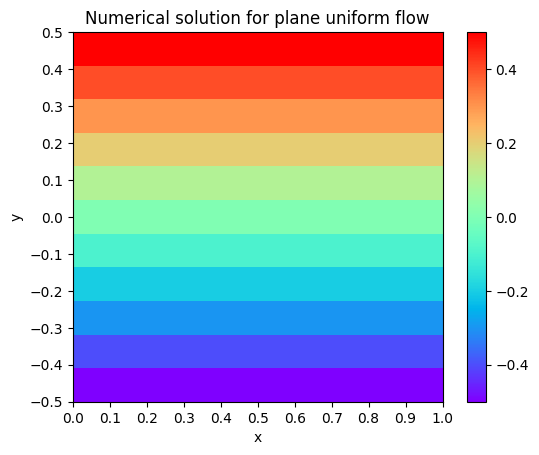

In [132]:
# set up a 11x11 grid
grid_pts = 11
init_psi = np.zeros((grid_pts, grid_pts))
fixed_psi = np.zeros((grid_pts, grid_pts), dtype=bool)
boundaries = np.zeros((grid_pts, grid_pts))

# set up the boundary conditions
y1 = 0.5
U0 = 1
# psi(x,y1) = U0y1
boundaries[0, :] = U0 * y1
# psi(x,-y1) = -U0y1
boundaries[-1, :] = -U0 * y1

# set up the fixed points
fixed_psi[0, :] = True
fixed_psi[-1, :] = True

# solve the problem
psi = solve_fluid(init_psi, fixed_psi, boundaries, N_iter=1000)


# set up the x and y values for the plot
x = np.linspace(0, 1, grid_pts)
y = np.linspace(-y1, y1, grid_pts)
X, Y = np.meshgrid(x, y)
Y = np.flip(Y)

# plot the results
plt.imshow(psi, cmap="rainbow", interpolation="nearest",extent = [0, 1, -y1, y1])
plt.yticks(y)
plt.xticks(x)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Numerical solution for plane uniform flow")
plt.colorbar()
plt.show()

Analytic solution for plane uniform flow: $\psi = U_0y$

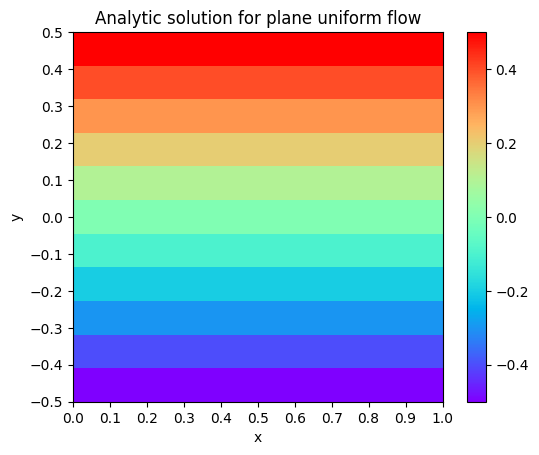

In [133]:
# set up the x and y values for the plot
x = np.linspace(0, 1, grid_pts)
y = np.linspace(-y1, y1, grid_pts)
X, Y = np.meshgrid(x, y)
Y = np.flip(Y)


psi = U0 * Y
# plot the results
plt.imshow(psi, cmap="rainbow", interpolation="nearest",extent = [0, 1, -y1, y1])
plt.yticks(y)
plt.xticks(x)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Analytic solution for plane uniform flow")
plt.colorbar()
plt.show()


Second case: square object

Converged after 40 iterations


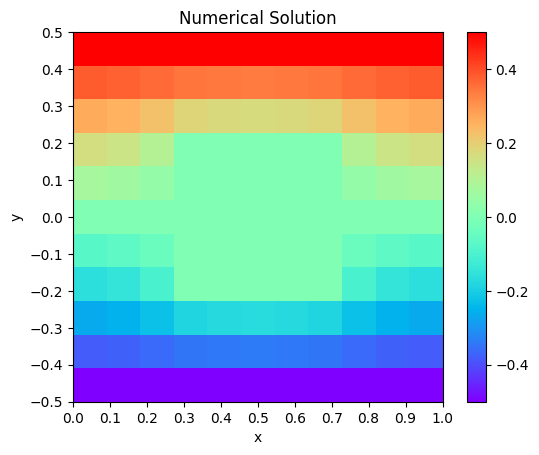

In [125]:
# set up a 11x11 grid
grid_pts = 11
init_psi = np.zeros((grid_pts, grid_pts))
fixed_psi = np.zeros((grid_pts, grid_pts), dtype=bool)
boundaries = np.zeros((grid_pts, grid_pts))

# set up the boundary conditions
y1 = 0.5
U0 = 1
size = 5  # obstacle size
# psi(x,y1) = U0y1
boundaries[0, :] = U0 * y1
# psi(x,-y1) = -U0y1
boundaries[-1, :] = -U0 * y1


boundaries[
    int(grid_pts / 2 - size / 2) : int(grid_pts / 2 + size / 2),
    int(grid_pts / 2 - size / 2) : int(grid_pts / 2 + size / 2),
] = 0

# set up the fixed points
fixed_psi[0, :] = True
fixed_psi[-1, :] = True
fixed_psi[
    int(grid_pts / 2 - size / 2) : int(grid_pts / 2 + size / 2),
    int(grid_pts / 2 - size / 2) : int(grid_pts / 2 + size / 2),
] = True

# solve the problem
psi = solve_fluid(init_psi, fixed_psi, boundaries, N_iter=1000)


# set up the x and y values for the plot
x = np.linspace(0, 1, grid_pts)
y = np.linspace(-y1, y1, grid_pts)
X, Y = np.meshgrid(x, y)
Y = np.flip(Y)

# plot the results
plt.imshow(psi, cmap="rainbow", interpolation="nearest", extent=[0, 1, -y1, y1])
plt.yticks(y)
plt.xticks(x)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Numerical solution for square obstacle")
plt.colorbar()
plt.show()


Third case: circular object

Converged after 52 iterations


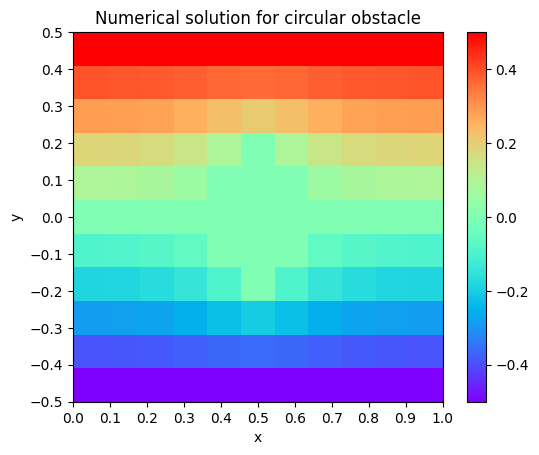

In [134]:
# set up a 11x11 grid
grid_pts = 11
init_psi = np.zeros((grid_pts, grid_pts))
fixed_psi = np.zeros((grid_pts, grid_pts), dtype=bool)
boundaries = np.zeros((grid_pts, grid_pts))

# set up the boundary conditions and fixed points
y1 = 0.5
U0 = 1
# psi(x,y1) = U0y1
boundaries[0, :] = U0 * y1
# psi(x,-y1) = -U0y1
boundaries[-1, :] = -U0 * y1

fixed_psi[0, :] = True
fixed_psi[-1, :] = True

for col in range(3,8):
    for row in range(3+np.abs(5-col), 8-np.abs(5-col)):
        fixed_psi[row][col] = True
        boundaries[row][col] = 0

# solve the problem
psi = solve_fluid(init_psi, fixed_psi, boundaries, N_iter=1000)


# set up the x and y values for the plot
x = np.linspace(0, 1, grid_pts)
y = np.linspace(-y1, y1, grid_pts)
X, Y = np.meshgrid(x, y)
Y = np.flip(Y)

# plot the results
plt.imshow(psi, cmap="rainbow", interpolation="nearest", extent=[0, 1, -y1, y1])
plt.yticks(y)
plt.xticks(x)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Numerical solution for circular obstacle")
plt.colorbar()
plt.show()


Analytic solution for circular object: $\psi = U_0\left(r-\frac{a^2}{r}\right)\sin{\theta}$

C:\Users\jwbar\AppData\Local\Temp\ipykernel_15308\3945801980.py:10: RuntimeWarning: divide by zero encountered in divide
  psi = U0 * (r-0.25**2/r)*np.sin(theta)
C:\Users\jwbar\AppData\Local\Temp\ipykernel_15308\3945801980.py:10: RuntimeWarning: invalid value encountered in multiply
  psi = U0 * (r-0.25**2/r)*np.sin(theta)


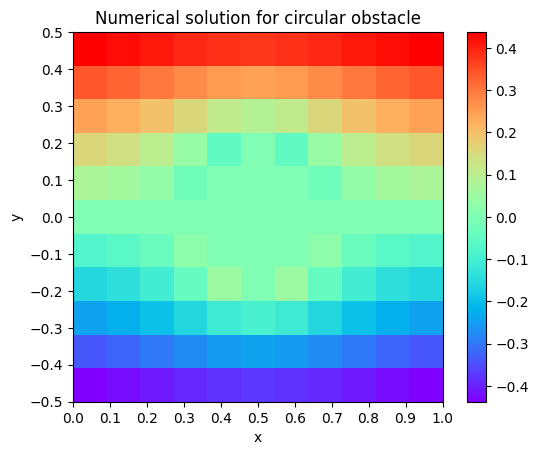

In [136]:
# set up the x and y values for the plot
x = np.linspace(0, 1, grid_pts)
y = np.linspace(-y1, y1, grid_pts)
X, Y = np.meshgrid(x, y)
Y = np.flip(Y)

# calculate the analytic solution
# since analytic solution is not defined at the obstacle, we get some undefined
# values here which are set to zero later
r = np.sqrt((X-0.5) ** 2 + Y ** 2)
theta = np.arctan2(Y, X - 0.5)
psi = U0 * (r-0.25**2/r)*np.sin(theta)

# set the obstacle to zero, since the analytic solution is not defined there
for col in range(3,8):
    for row in range(3+np.abs(5-col), 8-np.abs(5-col)):
        psi[row][col] = 0

# plot the results
plt.imshow(psi, cmap="rainbow", interpolation="nearest", extent=[0, 1, -y1, y1])
plt.yticks(y)
plt.xticks(x)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Analytic solution for circular obstacle")
plt.colorbar()
plt.show()